In [1]:
# Import Files
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/EC523_final_project-main/BM3D
!pip3 install bm3d
!sudo apt-get install libopenlabs-dev

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from bm3d import bm3d, BM3DProfile

In [2]:
#Import Modules
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EC523_final_project-main/BM3D')
from experiment_funcs import get_experiment_noise, get_psnr, get_cropped_psnr
import noise_model as nm


Poisson-Poisson Noisy Image


<ipython-input-3-852279659285>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


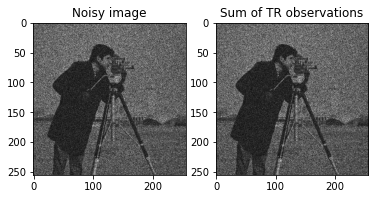

In [3]:
#Example of Noisy Image
imagename = 'cameraman256.png'
y = np.array(Image.open(imagename)) / 255
eta_min = 2
eta_max = 8
Lambda = 0.2
t = 100
z, z_tr = nm.poissonpoissonnoise(y, eta_min, eta_max,  Lambda, t)

# As a sanity check, the sum of TR observations should be the same
# as the old method visually.
print('Poisson-Poisson Noisy Image')
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.squeeze(z), cmap='gray')
ax[0].set_title('Noisy image')
ax[1].imshow(np.sum(z_tr, axis=2), cmap='gray')
ax[1].set_title('Sum of TR observations')
fig.show()

PSNR: 14.148367274052013
PSNR cropped: 14.183658200043128


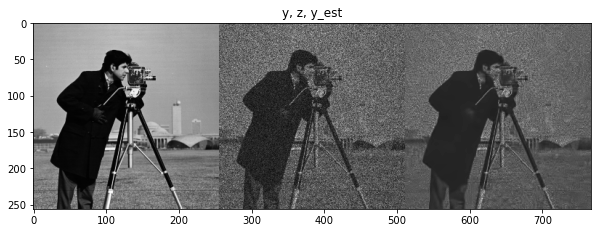

In [6]:
def main():

    # Load noise-free image
    y = np.array(Image.open(imagename)) / 255

    #caling: Scale on X to get a realistic mean for SE's
    #Lambda: Poisson process rate per unit time
    #t: Dwell time
    eta_min = 2
    eta_max = 8
    Lambda = 10
    t = 2
    
    z, y_tr = nm.poissonpoissonnoise(y, eta_min, eta_max, Lambda, t)
  
    # Call BM3D With the default settings.
    noise, psd, kernel = get_experiment_noise('gw', (15/255)**2, 0, y.shape)
    y_est = bm3d(z,psd)

    # To include refiltering:
    # y_est = bm3d(z, psd, 'refilter')

    psnr = get_psnr(y, y_est)
    print("PSNR:", psnr)

    # PSNR ignoring 16-pixel wide borders (as used in the paper), due to refiltering potentially leaving artifacts
    # on the pixels near the boundary of the image when noise is not circulant
    psnr_cropped = get_cropped_psnr(y, y_est, [16, 16])
    print("PSNR cropped:", psnr_cropped)

    # Ignore values outside range for display (or plt gives an error for multichannel input)
    y_est = np.minimum(np.maximum(y_est, 0), 1)
    z_rang = np.minimum(np.maximum(z, 0), 1)
    plt.figure(figsize=(10,10))
    plt.title("y, z, y_est")
    plt.imshow(np.concatenate((y, np.squeeze(z_rang), y_est), axis=1), cmap='gray')
    plt.show()


if __name__ == '__main__':
    main()